RANDOM FOREST CLASSIFICATION WITH LEAK-PROOF PIPELINE
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best Parameters (Pipeline): {'rf_classifier__max_depth': 8, 'rf_classifier__max_features': 'sqrt', 'rf_classifier__min_samples_leaf': 10, 'rf_classifier__n_estimators': 100}
Best Model Test Accuracy: 0.748


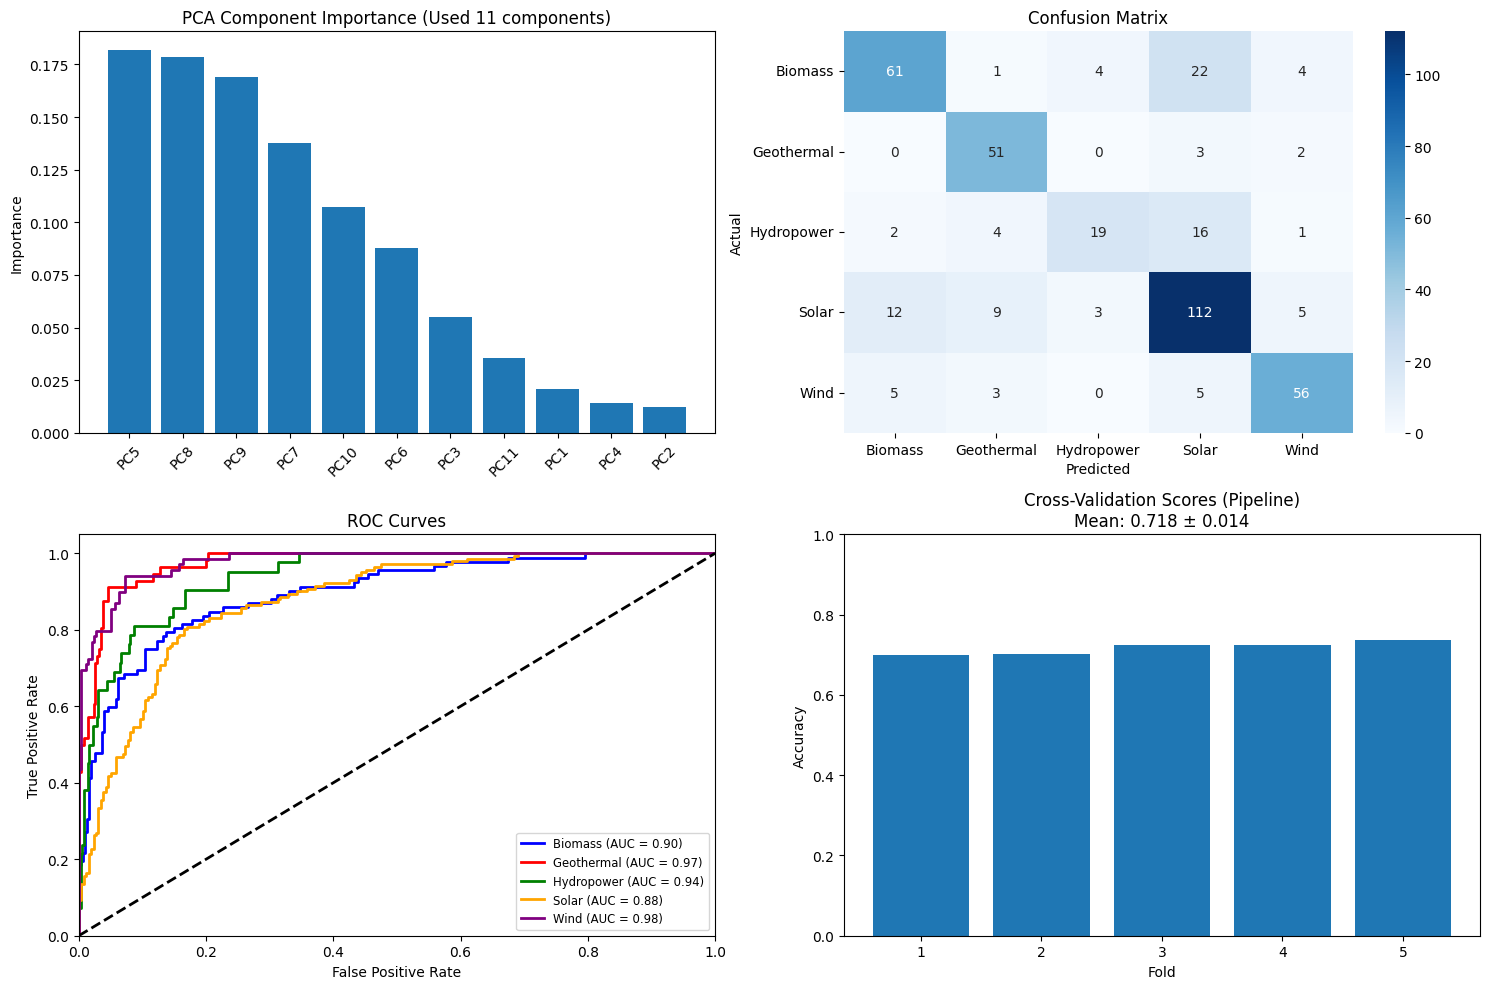


Classification Report (Optimized Pipeline Model):
              precision    recall  f1-score   support

     Biomass       0.76      0.66      0.71        92
  Geothermal       0.75      0.91      0.82        56
  Hydropower       0.73      0.45      0.56        42
       Solar       0.71      0.79      0.75       141
        Wind       0.82      0.81      0.82        69

    accuracy                           0.75       400
   macro avg       0.76      0.73      0.73       400
weighted avg       0.75      0.75      0.74       400


TRAINING vs TESTING ACCURACY (CLASSIFICATION)
Optimized Random Forest (Pipeline):
  Training Accuracy: 0.7994
  Testing Accuracy:  0.7475
  Difference:        0.0519
  Overfitting:       No


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (classification_report, confusion_matrix,
                           accuracy_score, roc_curve, auc)
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Assuming df, X_df, optimal_renewable_energy are already defined from your environment
# We start with raw X_df (the domain features) and y_class_encoded (the target variable)

print("="*60)
print("RANDOM FOREST CLASSIFICATION WITH LEAK-PROOF PIPELINE")
print("="*60)

# Prepare target variable for classification using the *original* df indices
y_class = df.loc[X_df.index, 'optimal_renewable_energy'].copy()
le = LabelEncoder()
y_class_encoded = le.fit_transform(y_class)

# Train-test split on RAW data (X_df is raw features, NOT PCA yet)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_df, y_class_encoded, test_size=0.2, random_state=42, stratify=y_class_encoded
)

# 1. Define the Pipeline: Scaler -> PCA -> Random Forest
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.9)), # Keep 90% variance automatically
    ('rf_classifier', RandomForestClassifier(random_state=42))
])

# 2. Hyperparameter Tuning using GridSearchCV on the Pipeline
# Focusing tuning parameters on regularization to reduce overfitting
param_grid_pipeline = {
    'rf_classifier__n_estimators': [50, 100, 150],
    # Enforce shallower trees than the previous code
    'rf_classifier__max_depth': [3, 5, 8],
    # Enforce more samples per leaf
    'rf_classifier__min_samples_leaf': [5, 10, 20],
    'rf_classifier__max_features': ['sqrt', 'log2']
}

grid_search_pipe = GridSearchCV(
    pipeline,
    param_grid_pipeline,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
# Fit the pipeline to the raw training data
grid_search_pipe.fit(X_train_raw, y_train)

# Best model from the leak-proof CV
best_pipe = grid_search_pipe.best_estimator_
y_pred_pipe = best_pipe.predict(X_test_raw)
y_pred_proba_pipe = best_pipe.predict_proba(X_test_raw)

print(f"\nBest Parameters (Pipeline): {grid_search_pipe.best_params_}")
print(f"Best Model Test Accuracy: {accuracy_score(y_test, y_pred_pipe):.3f}")

# 3. Feature Importance Plot (relative to PCA components)
# We need to extract the final RF model after fitting
final_rf_model = best_pipe.named_steps['rf_classifier']
importances = final_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
# Get the number of components the *final* model used
n_components_final = best_pipe.named_steps['pca'].n_components_

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.title(f'PCA Component Importance (Used {n_components_final} components)')
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [f'PC{indices[i]+1}' for i in range(len(importances))], rotation=45)
plt.ylabel('Importance')

# 4. Confusion Matrix
plt.subplot(2, 2, 2)
cm = confusion_matrix(y_test, y_pred_pipe)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 5. ROC Curves (for multi-class)
plt.subplot(2, 2, 3)
n_classes = len(le.classes_)
fpr = dict()
tpr = dict()
roc_auc = dict()

y_test_bin = label_binarize(y_test, classes=range(n_classes))
y_pred_proba_pipe_array = y_pred_proba_pipe

colors = ['blue', 'red', 'green', 'orange', 'purple']
for i in range(min(n_classes, len(colors))):
    if n_classes > 2:
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba_pipe_array[:, i])
    else: # Handle binary case explicitly if needed
        fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_proba_pipe_array[:, 1])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'{le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(fontsize='small')

# 6. Cross-validation scores (using the full pipeline)
# Note: This step re-runs CV but is a great health check.
plt.subplot(2, 2, 4)
# We use the full raw dataset here, CV splits handle everything internally
cv_scores = cross_val_score(best_pipe, X_df, y_class_encoded, cv=5, n_jobs=-1)
plt.bar(range(1, 6), cv_scores)
plt.title(f'Cross-Validation Scores (Pipeline)\nMean: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim([0, 1])

plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report (Optimized Pipeline Model):")
print(classification_report(y_test, y_pred_pipe, target_names=le.classes_))

# ==============================================================================
# MODEL PERFORMANCE SUMMARY & Overfitting Check
# ==============================================================================

print("\n" + "="*50)
print("TRAINING vs TESTING ACCURACY (CLASSIFICATION)")
print("="*50)

# Best model accuracies (using the pipeline structure correctly)
train_acc_pipe = best_pipe.score(X_train_raw, y_train)
test_acc_pipe = best_pipe.score(X_test_raw, y_test)

print("Optimized Random Forest (Pipeline):")
print(f"  Training Accuracy: {train_acc_pipe:.4f}")
print(f"  Testing Accuracy:  {test_acc_pipe:.4f}")
print(f"  Difference:        {abs(train_acc_pipe - test_acc_pipe):.4f}")
print(f"  Overfitting:       {'Yes' if train_acc_pipe - test_acc_pipe > 0.055 else 'No'}")

